# EVC for bound-state square well compared to orthogonal

Here we do tests of eigenvector continuation (EVC) for the bound states of a square well.

The particular goal here is to compare an orthogonal basis of the same size to an EVC basis.

In this notebook, we compute the eigenvalues $E_n$ of the potential with $V = -V_0$ for $r<R$ and $V=0$ for $r>R$.  The derivation can be found in any graduate and many undergraduate quantum mechanics texts.

## $\ell = 0$

The $\ell=0$ case is quite simple.  Inside the well, the radial function has the form $u(r) = A \sin(k r)$, with $k$ given by 

$$
k = \sqrt{2 \mu (V_0 + E_n)}/\hbar 
$$

while outside the well the radial function has the form $u(r) = B e^{-\kappa r}$, with $\kappa$ given by

$$
\kappa = \sqrt{-2 \mu E_n} \hbar
$$

In these definitions, $V_0 > 0$ and $E_n < 0$, $\mu$ is the reduced mass and $\hbar$ is Planck's constant divided by $2\pi$.   The eigenvalue condition is found by matching the radial wave function and its derivative (or, equivalently, its logarithmic derivative) at $r = R$.  This implies that the function $f(E_n)$:

$$
f(E_n) = \kappa/k + 1/\tan(k R)
$$

is zero at eigenvalues $E_n$.  We can plot this function to see graphically where the eigenvalues lie and then use routines from `scipy.optimize` to get numerical values.

## $\ell > 0$

For $\ell > 0$, the interior solution is a Riccati-Bessel function.

## General set up

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.integrate import simps, quadrature
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.linalg import eig, eigh

from integration import Gaussian_quadrature, Gaussian_mesh
from square_well import SquareWell, rMeshSW, rGaussSW
from evc import SW_matrix_element, SW_matrix_element_simps, SW_matrix_element_gauss
from evc import EigenvectorContinuationScattering

In [2]:
fig_dir = 'figures_bound_states_ortho/'

In [3]:
from graphs import setup_rc_params
setup_rc_params(presentation=True)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
mpl.rcParams['figure.constrained_layout.use'] = False


## Harmonic oscillator basis functions

We'll start `nHO` at 0 and take `Nmax = 2n+l`.  For `l=0`, `Nmax = 0,2,4,6,...`

In [53]:
from scipy.special import gamma, factorial, assoc_laguerre

def bHO(hbarOmega, mu=1):
    # return the HO length scale b given the oscillator
    return np.sqrt(1/(mu * hbarOmega))

def normHO(nHO, lHO, bHO): 
    # return the normalization constant for an oscillator with nHO and lHO
    return np.sqrt(2 * factorial(nHO) / (bHO * gamma(nHO + lHO + 3/2)))

def phiHO(nHO, lHO, bHO, r):
    # return the normalized HO wave function at r
    q = r / bHO
    HO_wf = normHO(nHO, lHO, bHO) * q**(lHO + 1) \
             * assoc_laguerre(q**2, nHO, lHO + 1/2) * np.exp(-q**2 / 2)
    return HO_wf

Check normalization

In [54]:
print(normHO(1,1,1))

0.7757591265663202


In [55]:
phiHO(1,1,1,1)

0.7057825422215498

In [103]:
hbarOmega = 3
bHO_a = bHO(hbarOmega)
r_test = np.arange(0,10.,.002)
phiHO_0 = np.array([phiHO(0,0,bHO_a, r) for r in r_test])
phiHO_1 = np.array([phiHO(1,0,bHO_a, r) for r in r_test])
phiHO_2 = np.array([phiHO(2,0,bHO_a, r) for r in r_test])

norm_0 = simps(x=r_test, y=phiHO_0**2)
norm_1 = simps(x=r_test, y=phiHO_1**2)
norm_2 = simps(x=r_test, y=phiHO_2**2)
orth_02 = simps(x=r_test, y=phiHO_0*phiHO_1)
print(norm_0, norm_1, norm_2, orth_02)

1.0000000078175466 1.0000000117261318 1.00000001465743 9.574423227135348e-09


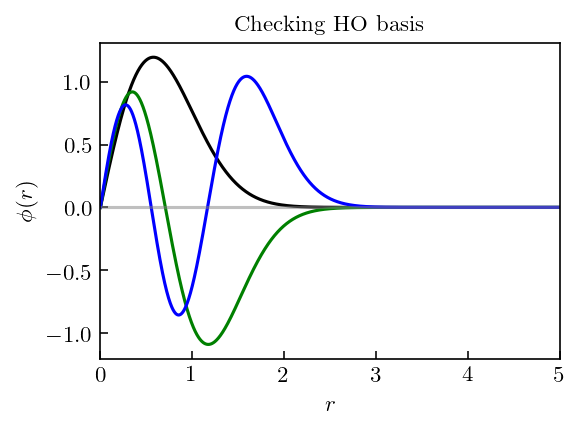

In [104]:
# plot the zeros to check.
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(r_test, phiHO_0, color='black')
ax.plot(r_test, phiHO_1, color='green')
ax.plot(r_test, phiHO_2, color='blue')
ax.set_xlim(0, 5)
#ax.set_ylim(-10, 10)
ax.axhline(0.0, color='gray', alpha=0.5)
ax.set_title('Checking HO basis')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$\phi(r)$')

fig.tight_layout()

In [96]:
def H_ij_HO(num_terms, V0, hbarOmega, mu=1, R=1):
    """
    Hamiltonian matrix in the HO basis
    """
    bHO_a = bHO(hbarOmega)
    lHO = 0
    r_mesh = np.arange(0,10.,.002)
    num_pts = len(r_mesh)
    print(num_pts)

    integrand = np.zeros(num_pts)
    H_mat = np.zeros((num_terms, num_terms))
    for i in range(num_terms):
        for j in range(num_terms):
            for index, r in enumerate(r_mesh):
                phi_j = phiHO(j, lHO, bHO_a, r)
                phi_i = phiHO(i, lHO, bHO_a, r)
                Vho = 1/2 * mu * hbarOmega**2 * r**2
                EHO = hbarOmega * (2*i + lHO + 3/2)
                Vsw = np.where(r > R, 0., -V0)
                integrand[index] = phi_j * (EHO - Vho + Vsw) * phi_i
            H_mat[i,j] = simps(x=r_mesh, y=integrand)

    # check for symmetry
    if not np.allclose(H_mat, np.asmatrix(H_mat).H):
        print('Hamiltonian matrix is not symmetric.')
        print('Symmetrizing for now')
        H_mat = (H_mat + H_mat.T) / 2.
        #raise ValueError('expected symmetric or Hermitian matrix')

    # check condition number
    H_cond_num = np.linalg.cond(H_mat)
    #print(f'condition number = {np.linalg.cond(H_mat):.4e}')

    return H_mat        


In [118]:
def H_ij_HO_acc_integrand(r, i, j, hbarOmega, lHO=0, R=1):
    bHO_a = bHO(hbarOmega)
    phi_j = phiHO(j, lHO, bHO_a, r)
    phi_i = phiHO(i, lHO, bHO_a, r)
    Vho = 1/2 * mu * hbarOmega**2 * r**2
    EHO = hbarOmega * (2*i + lHO + 3/2)
    Vsw = np.where(r > R, 0., -V0)
    return phi_j * (EHO - Vho + Vsw) * phi_i
    

In [126]:
def H_ij_HO_acc(num_terms, V0, hbarOmega, mu=1, R=1):
    """
    Hamiltonian matrix in the HO basis with accurate integration
    """
    bHO_a = bHO(hbarOmega)
    lHO = 0
    R_max = 20.

    H_mat = np.zeros((num_terms, num_terms))
    for i in range(num_terms):
        for j in range(num_terms):
            my_tol = 1.e-10
            # using scipy.integrate.quadrature
            int_in, err = quadrature(H_ij_HO_acc_integrand, 0, R, 
                                     args=(i,j,hbarOmega), tol=my_tol, rtol=my_tol)
            int_out, err = quadrature(H_ij_HO_acc_integrand, R, R_max, 
                                     args=(i,j,hbarOmega), tol=my_tol, rtol=my_tol)
            H_mat[i,j] = int_in + int_out

    # check for symmetry
    if not np.allclose(H_mat, np.asmatrix(H_mat).H):
        #print('Hamiltonian matrix is not symmetric.')
        #print('Symmetrizing for now')
        H_mat = (H_mat + H_mat.T) / 2.
        #raise ValueError('expected symmetric or Hermitian matrix')

    # check condition number
    H_cond_num = np.linalg.cond(H_mat)
    #print(f'condition number = {np.linalg.cond(H_mat):.4e}')

    return H_mat        


In [120]:
V0 = 20.

num_terms = 6
hbarOmega = 3
H_mat_HO = H_ij_HO(num_terms, V0, hbarOmega)
eig_vals_HO, eig_vecs_HO = eigh(H_mat_HO)

print(f'eigenvalue = {np.min(eig_vals_HO):8.3f}')

5000
Hamiltonian matrix is not symmetric.
Symmetrizing for now
condition number = 1.3317e+01
eigenvalue =  -16.313


In [114]:
V0 = 10.

num_terms = 6
hbarOmega = 3
H_mat_HO = H_ij_HO_acc(num_terms, V0, hbarOmega)
eig_vals_HO, eig_vecs_HO = eigh(H_mat_HO)

print(f'eigenvalue = {np.min(eig_vals_HO):12.8f}')

5000
condition number = 3.2771e+01
eigenvalue =  -6.75740350


## Tests

Set the reduced mass and $\hbar$ to one. Try some different square wells.

### Check that the transcendental function is correct

In [5]:
# Make a plot of the zeros of the transcendental function (i.e., find E_n) 
mu = 1.; hbar = 1; 

# Create a square well
R = 1.; V0 = 2.2;

# Specify the mesh
r_max = 10.
num_pts = 1000 
gauss_pts = 48

sw1 = SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts, r_max=r_max)

# Start the energy array a bit above -V0 until almost zero
E_pts = np.linspace(-V0+.001, -0.01, 1000)
transcendental_pts = sw1.f_sw(E_pts)


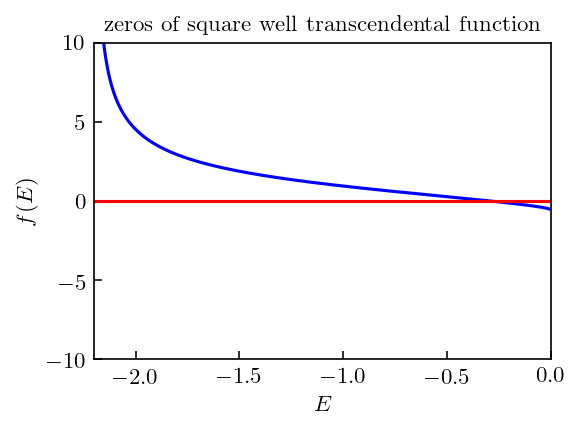

In [6]:
# plot the zeros to check.
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(E_pts, transcendental_pts, color='blue')
ax.set_xlim(-V0, 0.)
ax.set_ylim(-10, 10)
ax.axhline(0.0, color='red')
ax.set_title('zeros of square well transcendental function')
ax.set_xlabel(r'$E$')
ax.set_ylabel(r'$f(E)$')

fig.tight_layout()

In [7]:
def find_solutions(sw_params_array):
    """
    Function to step through the pairs of (V0, R) parameters in 
    sw_params_array and find the ground state energy for each.
    """
    
    for (V0, R) in sw_params_array:
        sw = SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts, r_max=r_max)
        print(sw.E0)
        
sw_array = np.array([[20., 1], [18., 1], [20., 2]])  
find_solutions(sw_array)

-16.353799211781638
-14.412060528881355
-18.94185232612673


In [8]:
mu = 1.; hbar = 1; 

# Create a square well
R = 1.; V0 = 1.2;

# Specify the mesh
r_max = 10.
num_pts = 1000 
gauss_pts = 48

my_sw = SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts, r_max=r_max)

Egs_wf = my_sw.norm_wf_simps()
print(f'ground state energy = {my_sw.E0}')

ground state energy = -0.0008951338608253756


/Users/furnstah/Dropbox/git_rjf/EVC_stuff/EVC_tests/square_well.py:198: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(-2. * self.mu * E) / self.hbar
/Users/furnstah/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


### Check the wave function for continuity and normalization

normalization =  1.000000279402407
norm split reconstruct =  1.0
norm function = 1.0

Now with Gaussian quadrature . . .
gauss normalization =  1.0
norm function = 1.0


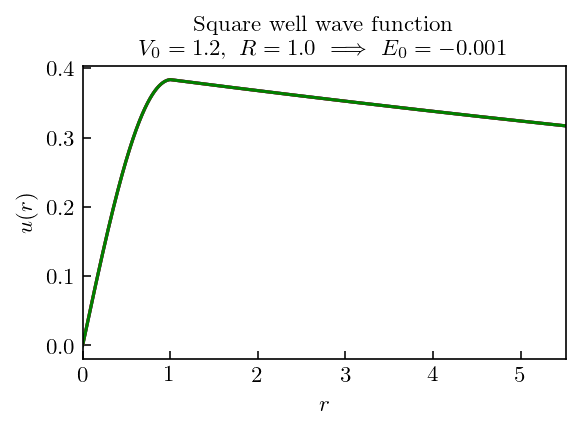

In [9]:
# make a plot and check normalization
my_r_pts = my_sw.r_mesh.r_pts

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(my_r_pts, my_sw.E0_wf_simps, color='blue')
ax.plot(my_sw.gauss_mesh.nodes, my_sw.E0_wf_gauss, color='red')
ax.plot(my_r_pts, my_sw.norm_wf(my_r_pts), color='green')
ax.set_xlim(my_r_pts[0], my_r_pts[1500])
#ax.set_ylim(-10, 10)
#ax.axhline(0.0, color='red')
title_string = rf'Square well wave function' + '\n' + \
               rf'$V_0 = {my_sw.V0},\ R = {my_sw.R} \ \Longrightarrow\ E_0 = {my_sw.E0:.3f}$'
ax.set_title(title_string)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$u(r)$')

fig.tight_layout()

# check normalization
print('normalization = ', simps(my_sw.E0_wf_simps**2, my_r_pts))
print('norm split reconstruct = ',
      simps(my_sw.E0_wf_simps[:my_sw.r_mesh.num_in_pts]**2, 
            my_sw.r_mesh.r_in_pts) +
      simps(my_sw.E0_wf_simps[my_sw.r_mesh.num_in_pts-1:]**2, 
            my_sw.r_mesh.r_out_pts) 
     )
print('norm function =', 
       SW_matrix_element_simps(my_sw.E0_wf_simps, my_sw.E0_wf_simps, 
                               my_sw.r_mesh))

# check normalization with gaussian quadrature
print('\nNow with Gaussian quadrature . . .')
print('gauss normalization = ', my_sw.E0_wf_gauss**2 @ my_sw.gauss_mesh.weights)
print('norm function =', 
       SW_matrix_element_gauss(my_sw.E0_wf_gauss, my_sw.E0_wf_gauss, 
                               my_sw.gauss_mesh.nodes, 
                               my_sw.gauss_mesh.weights))

### Test expectation values

In [10]:
# Test the expectation value of the Hamiltonian
# Compare calculations that don't account for the discontuity to ones
#  that do.
my_r_pts = my_sw.r_mesh.r_pts
my_E0_wf = my_sw.E0_wf_simps
T_expectation = simps(my_E0_wf * my_sw.T_on_E0_wf_simps, my_r_pts)
T_alt_expectation = simps(my_E0_wf * my_sw.T_on_E0_wf_alt_simps, my_r_pts)
T_me_expectation = SW_matrix_element_simps(my_E0_wf, 
                                           my_sw.T_on_E0_wf_alt_simps, 
                                           my_sw.r_mesh)
V_expectation = simps(my_E0_wf**2 * my_sw.Vsw(my_r_pts), my_r_pts)
V_me_expectation = SW_matrix_element_simps(my_E0_wf, my_E0_wf, my_sw.r_mesh,
                                           my_sw.Vsw(my_r_pts))

E0_expectation = T_expectation + V_expectation
E0_me_expectation = T_me_expectation + V_me_expectation
                 
print(f'actual E0 = {my_sw.E0:.12f}, ',
      f'E0_exp = {E0_expectation:.12f}, ',  
      f'E0_me_exp = {E0_me_expectation:.12f}, \n',  
      f'T_exp = {T_expectation:.12f}, ',          
      f'T_alt_exp = {T_alt_expectation:.12f},',          
      f'T_me_exp = {T_me_expectation:.12f}, \n',          
      f'V_exp = {V_expectation:.12f} ,',
      f'V_me_exp = {V_me_expectation:.12f}')          

actual E0 = -0.000895133861,  E0_exp = -0.000895134111,  E0_me_exp = -0.000895133861, 
 T_exp = 0.087249324287,  T_alt_exp = 0.087249324287, T_me_exp = 0.086877480834, 
 V_exp = -0.088144458398 , V_me_exp = -0.087772614695


In [11]:
# Gaussian quadrature version
# Test the expectation value of the Hamiltonian
# Compare calculations that don't account for the discontuity to ones
#  that do.
my_nodes = my_sw.gauss_mesh.nodes
my_weights = my_sw.gauss_mesh.weights
T_expectation = (my_sw.E0_wf_gauss * my_sw.T_on_E0_wf_gauss) @ my_weights                
T_alt_expectation = (my_sw.E0_wf_gauss * my_sw.T_on_E0_wf_alt_gauss) @ \
                     my_weights
T_me_expectation = SW_matrix_element_gauss(my_sw.E0_wf_gauss, 
                                           my_sw.T_on_E0_wf_alt_gauss,
                                           my_nodes, my_weights)
V_expectation = (my_sw.E0_wf_gauss**2 * my_sw.Vsw(my_nodes)) @ my_weights
V_me_expectation = SW_matrix_element_gauss(my_sw.E0_wf_gauss, 
                                           my_sw.E0_wf_gauss, 
                                           my_nodes, my_weights,
                                           my_sw.Vsw(my_nodes))

E0_expectation = T_expectation + V_expectation
E0_me_expectation = T_me_expectation + V_me_expectation
          
print('Gaussian quadrature check of expectation values')    
print(f'actual E0 = {my_sw.E0:.12f}, ',
      f'E0_exp = {E0_expectation:.12f}, ',  
      f'E0_me_exp = {E0_me_expectation:.12f}, \n',  
      f'T_exp = {T_expectation:.12f}, ',          
      f'T_alt_exp = {T_alt_expectation:.12f},',          
      f'T_me_exp = {T_me_expectation:.12f}, \n',          
      f'V_exp = {V_expectation:.12f} ,',
      f'V_me_exp = {V_me_expectation:.12f}')          

Gaussian quadrature check of expectation values
actual E0 = -0.000895133861,  E0_exp = -0.000895133861,  E0_me_exp = -0.000895133861, 
 T_exp = 0.086214332369,  T_alt_exp = 0.086214332369, T_me_exp = 0.086214332369, 
 V_exp = -0.087109466229 , V_me_exp = -0.087109466229


### Make some tables and figures

In [12]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [13]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [14]:
def set_ticks(ax, x_major, x_minor, y_major=None, y_minor=None, 
              x_fmt='%d', y_fmt='%d'):
    """
    Set up the major ticks at every major, with labels, and minor ticks at minor.
    """# 
    ax.xaxis.set_major_locator(MultipleLocator(x_major))
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_fmt))
    ax.xaxis.set_minor_locator(MultipleLocator(x_minor))

    if (y_major):
        ax.yaxis.set_major_locator(MultipleLocator(y_major))
        ax.yaxis.set_major_formatter(FormatStrFormatter(y_fmt))
    if (y_minor):
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor))


In [15]:
# Make an array of square wells, specified by an array of parameters
mu = 1
num_pts = 4000
r_max = 20.
gauss_pts = 48

sw_params_array = np.array([[30., 1.], [20., 1.], [15., 1.], [10., 1.], [0.2, 1.]])  

sw_array = [SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts,
                       r_max=r_max) for 
             (V0, R) in sw_params_array]

V0_ref_pts = [sw.V0 for sw in sw_array]
E0_ref_pts = [sw.E0 for sw in sw_array]

# Make an EVC object
my_evc = EigenvectorContinuationScattering(sw_array)

# Step through test values
test_R = sw_array[0].R
test_mu = sw_array[0].mu

test_V0_pts = np.arange(1., 30., 0.1)
exact_E_pts = []
EVC_E_pts = []
abs_err_E_pts = []
rel_err_E_pts = []
test_i = 5

print(f'All potentials have R = {sw_array[0].R}')
print(f'Results with {test_i} basis functions with ',
      f'V0 = {[sw.V0 for sw in sw_array[0:test_i]]}')
print(f'\n   V0         exact             EVC        abs err  rel err')
for index, V0 in enumerate(test_V0_pts):
    test_theta = [V0, test_R]
    test_sw = SquareWell(V0, test_R, test_mu, num_pts=num_pts, 
                         gauss_pts=gauss_pts, r_max=r_max)
    exact_E = test_sw.E0
    exact_E_pts = np.append(exact_E_pts, exact_E)
    EVC_E = my_evc.find_EVC_gauss(test_i, test_theta)[0]
    EVC_E_pts = np.append(EVC_E_pts, EVC_E)
    abs_err_E = np.abs(EVC_E - exact_E)
    abs_err_E_pts = np.append(abs_err_E_pts, abs_err_E)
    rel_err_E = np.abs((EVC_E - exact_E) / exact_E)
    rel_err_E_pts = np.append(rel_err_E_pts, rel_err_E)
    if (index % 10 == 0):
        print(f'  {V0:4.1f}   {exact_E:14.10f}   {EVC_E:14.10f}',
              f'  {abs_err_E:.1e}  {rel_err_E:.1e}'  )
    
# for i in np.arange(1, len(sw_array)+1):
#     eigvals = my_evc.find_EVC_gauss(i, test_theta)
#     print(f'{eigvals}',
#           f'  cond. #: N = {my_evc.N_cond_num:.2e}',
#           f'  H = {my_evc.H_cond_num:.2e}')



All potentials have R = 1.0
Results with 5 basis functions with  V0 = [30.0, 20.0, 15.0, 10.0, 0.2]

   V0         exact             EVC        abs err  rel err
   1.0    -0.1695966689    -0.4093091904   2.4e-01  1.4e+00


/Users/furnstah/Dropbox/git_rjf/EVC_stuff/EVC_tests/square_well.py:198: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(-2. * self.mu * E) / self.hbar
/Users/furnstah/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


   2.0    -0.2035507418    -0.6512616095   4.5e-01  2.2e+00
   3.0    -0.7814787639    -1.0715700567   2.9e-01  3.7e-01
   4.0    -1.5088054389    -1.6807935630   1.7e-01  1.1e-01
   5.0    -2.3120970432    -2.4196648047   1.1e-01  4.7e-02
   6.0    -3.1606841058    -3.2334857083   7.3e-02  2.3e-02
   7.0    -4.0390249043    -4.0917432286   5.3e-02  1.3e-02
   8.0    -4.9382348617    -4.9784396871   4.0e-02  8.1e-03
   9.0    -5.8527947604    -5.8846687968   3.2e-02  5.4e-03
  10.0    -6.7790600214    -6.8050778194   2.6e-02  3.8e-03
  11.0    -7.7145084004    -7.7362253769   2.2e-02  2.8e-03
  12.0    -8.6573282030    -8.6757742073   1.8e-02  2.1e-03
  13.0    -9.6061781292    -9.6220656960   1.6e-02  1.7e-03
  14.0   -10.5600398804   -10.5738805745   1.4e-02  1.3e-03
  15.0   -11.5181238197   -11.5302964900   1.2e-02  1.1e-03
  16.0   -12.4798064255   -12.4905990341   1.1e-02  8.6e-04
  17.0   -13.4445875628   -13.4542238384   9.6e-03  7.2e-04
  18.0   -14.4120605289   -14.4207175491

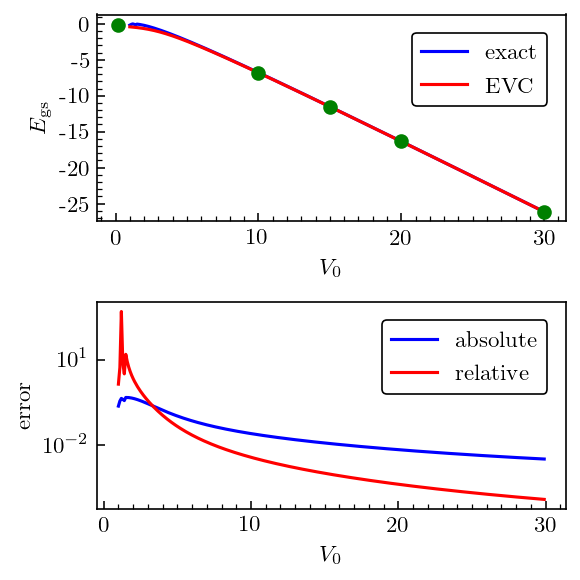

In [16]:
#### from graphs import setup_rc_params
setup_rc_params(presentation=True)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
mpl.rcParams['figure.constrained_layout.use'] = False

fig = plt.figure(figsize=(4,4))
overall_title = rf'Eigenvector continuation for square well ' + \
                rf' $\ell=0$ ground state:  ' + \
                 rf' $R = {sw_array[0].R}$' 
#fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(2,1,1)                  

#start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(test_V0_pts, exact_E_pts, 
            axis_labels=(r'$V_0$',rf'$E_{{\rm gs}}$'), 
            color='blue',
            label=r'exact', 
            ax=ax_a)    
plot_y_vs_x(test_V0_pts, EVC_E_pts, 
            axis_labels=(r'$V_0$',rf'$E_{{\rm gs}}$'), 
            color='red',
            label=r'EVC', 
            ax=ax_a) 
ax_a.plot(V0_ref_pts[:test_i], E0_ref_pts[:test_i], 'o', color='green')
set_ticks(ax_a, x_major=10, x_minor=1, y_major=5, y_minor=1)

ax_b = fig.add_subplot(2,1,2)                  
plot_y_vs_x(test_V0_pts, abs_err_E_pts, 
            axis_labels=(r'$V_0$',r'error'), 
            semilogy=True,
            color='blue',
            label=r'absolute', 
            ax=ax_b)    
plot_y_vs_x(test_V0_pts, rel_err_E_pts, 
            axis_labels=(r'$V_0$',r'error'),
            semilogy=True,
            color='red',
            label=r'relative', 
            ax=ax_b)    
set_ticks(ax_b, x_major=10, x_minor=1)

fig.tight_layout()

fig_filename = fig_dir + f'EVC_{test_i}.png'
#fig.savefig(fig_filename, bbox_inches='tight')  

In [17]:
sw_array

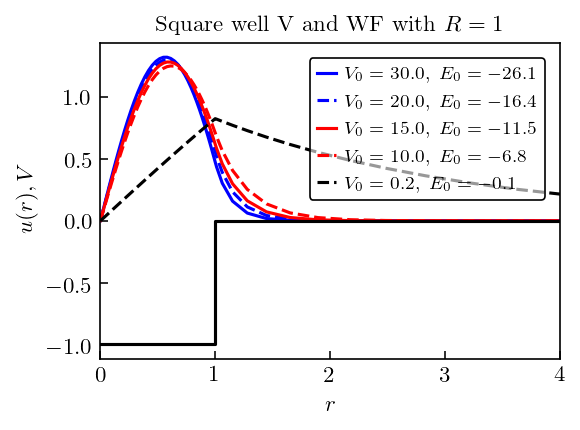

In [18]:
# make a plot and check normalization
my_r_pts = my_sw.r_mesh.r_pts

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ls= ['b-', 'b--', 'r-', 'r--', 'k--' ] 
for i, my_sw in enumerate(sw_array):
    ax.plot(my_sw.gauss_mesh.nodes, my_sw.E0_wf_gauss, ls[i], label=rf'$V_0 = {my_sw.V0},\ E_0 = {my_sw.E0:.1f}$')
ax.set_xlim(0, 4)
#ax.set_ylim(-10, 10)
#ax.axhline(0.0, color='red')
title_string = rf'Square well V and WF with $R=1$'
ax.legend(loc='best', fontsize=9, ncol=1 , columnspacing=1, handlelength=1, handletextpad=0.5) 
ax.set_title(title_string)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$u(r), V$')

ax.plot(np.array([0, 1, 1, 4]), np.array([-1, -1, 0, 0]), 'k-')

fig.tight_layout()


In [133]:
# Make an array of square wells, specified by an array of parameters
mu = 1
num_pts = 4000
r_max = 20.
gauss_pts = 48

sw_params_array = np.array([[12., 1.], [10., 1.], [8., 1.], [6., 1.], [4, 1.]])  

sw_array = [SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts,
                       r_max=r_max) for 
             (V0, R) in sw_params_array]

V0_ref_pts = [sw.V0 for sw in sw_array]
E0_ref_pts = [sw.E0 for sw in sw_array]

# Make an EVC object
my_evc = EigenvectorContinuationScattering(sw_array)

# Step through test values
test_R = sw_array[0].R
test_mu = sw_array[0].mu

test_V0_pts = np.arange(1., 30., 0.1)
exact_E_pts = []
EVC_E_pts = []
HO_E_pts = []
abs_err_E_pts = []
rel_err_E_pts = []
abs_err_HO_E_pts = []
rel_err_HO_E_pts = []
test_i = 5

print(f'All potentials have R = {sw_array[0].R}')
print(f'Results with {test_i} basis functions with ',
      f'V0 = {[sw.V0 for sw in sw_array[0:test_i]]}')
print(f'\n   V0         exact             EVC        abs err  rel err', \
     f'      HO basis   abs err   rel err')
for index, V0 in enumerate(test_V0_pts):
    test_theta = [V0, test_R]
    test_sw = SquareWell(V0, test_R, test_mu, num_pts=num_pts, 
                         gauss_pts=gauss_pts, r_max=r_max)
    exact_E = test_sw.E0
    exact_E_pts = np.append(exact_E_pts, exact_E)
    EVC_E = my_evc.find_EVC_gauss(test_i, test_theta)[0]
    EVC_E_pts = np.append(EVC_E_pts, EVC_E)
    abs_err_E = np.abs(EVC_E - exact_E)
    abs_err_E_pts = np.append(abs_err_E_pts, abs_err_E)
    rel_err_E = np.abs((EVC_E - exact_E) / exact_E)
    rel_err_E_pts = np.append(rel_err_E_pts, rel_err_E)
    
    num_terms = 8
    hbarOmega = 1.5
    H_mat_HO = H_ij_HO_acc(num_terms, V0, hbarOmega)
    eig_vals_HO, eig_vecs_HO = eigh(H_mat_HO)
    HO_E_min = np.min(eig_vals_HO)
    HO_E_pts = np.append(HO_E_pts, HO_E_min)
    abs_err_HO_E = np.abs(HO_E_min - exact_E)
    abs_err_HO_E_pts = np.append(rel_err_HO_E_pts, abs_err_HO_E)
    rel_err_HO_E = np.abs((HO_E_min - exact_E)/exact_E)
    rel_err_HO_E_pts = np.append(rel_err_HO_E_pts, rel_err_HO_E)
    
    if (index % 10 == 0):
        print(f'  {V0:4.1f}   {exact_E:14.10f}   {EVC_E:14.10f}',
              f'  {abs_err_E:.1e}  {rel_err_E:.1e}'  ,
              f'  {HO_E_min:14.10f}  {abs_err_HO_E:.1e}  {rel_err_HO_E:.1e}')
        
        
    
# for i in np.arange(1, len(sw_array)+1):
#     eigvals = my_evc.find_EVC_gauss(i, test_theta)
#     print(f'{eigvals}',
#           f'  cond. #: N = {my_evc.N_cond_num:.2e}',
#           f'  H = {my_evc.H_cond_num:.2e}')



All potentials have R = 1.0
Results with 5 basis functions with  V0 = [12.0, 10.0, 8.0, 6.0, 4.0]

   V0         exact             EVC        abs err  rel err       HO basis   abs err   rel err
   1.0    -0.1695966689     0.1268937297   3.0e-01  1.7e+00    -0.9320242643  7.6e-01  4.5e+00


/Users/furnstah/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:245: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.554559e-02
  warnings.warn(


   2.0    -0.2035507418    -0.1992041797   4.3e-03  2.1e-02    -1.1811195504  9.8e-01  4.8e+00
   3.0    -0.7814787639    -0.7814352195   4.4e-05  5.6e-05    -1.5170660990  7.4e-01  9.4e-01
   4.0    -1.5088054389    -1.5088054389   1.6e-15  1.0e-15    -1.9646961605  4.6e-01  3.0e-01
   5.0    -2.3120970432    -2.3120970125   3.1e-08  1.3e-08    -2.5351795489  2.2e-01  9.6e-02
   6.0    -3.1606841058    -3.1606841058   4.4e-16  1.4e-16    -3.2170525837  5.6e-02  1.8e-02
   7.0    -4.0390249043    -4.0390249036   6.9e-10  1.7e-10    -3.9846597871  5.4e-02  1.3e-02
   8.0    -4.9382348617    -4.9382348617   2.7e-15  5.4e-16    -4.8123317718  1.3e-01  2.5e-02
   9.0    -5.8527947604    -5.8527947603   1.3e-10  2.3e-11    -5.6808329236  1.7e-01  2.9e-02
  10.0    -6.7790600214    -6.7790600214   8.9e-16  1.3e-16    -6.5773038620  2.0e-01  3.0e-02
  11.0    -7.7145084004    -7.7145084002   1.9e-10  2.4e-11    -7.4934077278  2.2e-01  2.9e-02
  12.0    -8.6573282030    -8.6573282030   1.8e-15

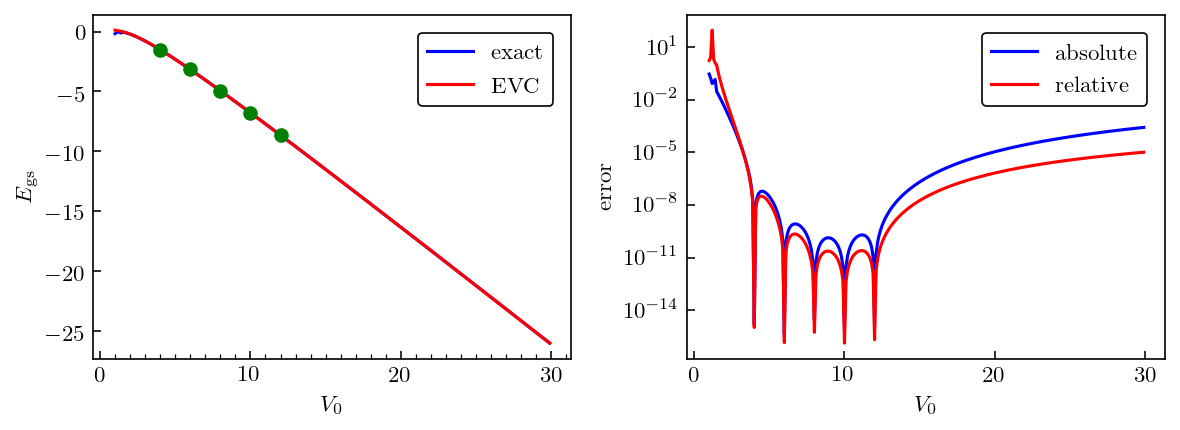

In [20]:
from graphs import setup_rc_params
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
setup_rc_params(presentation=True)
mpl.rcParams['figure.constrained_layout.use'] = False

fig = plt.figure(figsize=(8,3))
overall_title = rf'Eigenvector continuation for square well ' + \
                rf' $\ell=0$ ground state:  ' + \
                 rf' $R = {sw_array[0].R}$' 
#fig.suptitle(overall_title, va='baseline')

ax_a = fig.add_subplot(1,2,1)                  

#start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(test_V0_pts, exact_E_pts, 
            axis_labels=(r'$V_0$',rf'$E_{{\rm gs}}$'), 
            color='blue',
            label=r'exact', 
            ax=ax_a)    
plot_y_vs_x(test_V0_pts, EVC_E_pts, 
            axis_labels=(r'$V_0$',rf'$E_{{\rm gs}}$'), 
            color='red',
            label=r'EVC', 
            ax=ax_a) 
ax_a.plot(V0_ref_pts[:test_i], E0_ref_pts[:test_i], 'o', color='green')
ax_a.set_xticks(range(0,31,10))

# Set up the major ticks at every 10, with labels, and minor ticks at 1
ax_a.xaxis.set_major_locator(MultipleLocator(10))
ax_a.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax_a.xaxis.set_minor_locator(MultipleLocator(1))


ax_b = fig.add_subplot(1,2,2)                  
plot_y_vs_x(test_V0_pts, abs_err_E_pts, 
            axis_labels=(r'$V_0$',r'error'), 
            semilogy=True,
            color='blue',
            label=r'absolute', 
            ax=ax_b)    
plot_y_vs_x(test_V0_pts, rel_err_E_pts, 
            axis_labels=(r'$V_0$',r'error'),
            semilogy=True,
            color='red',
            label=r'relative', 
            ax=ax_b)    

fig.tight_layout()

fig_filename = fig_dir + f'EVC3_{test_i}.png'
fig.savefig(fig_filename, bbox_inches='tight')  

### More tests

In [21]:
# Make an array of square wells, specified by an array of parameters
mu = 1
num_pts = 2000
r_max = 20.
gauss_pts = 48

# Array elements are [V0, R]
sw_params_array = np.array([[16., 1], [14., 1], [12., 1], [24., 1], [22., 1], 
                            [20., 1], [18., 1], ])  
#sw_params_array = np.array([[20., 1], [12., 1], [20., 2], [16., 4]])  
#sw_params_array = np.array([[20., 1], [18., 1], [20., 2]])  

sw_array = [SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts,
                       r_max=r_max) for 
             (V0, R) in sw_params_array]

# Create an EVC object
my_evc = EigenvectorContinuationScattering(sw_array)

In [22]:
for sw in sw_array:
    print(f'ground state energy E0 = {sw.E0}')
    Egs_wf = sw.E0_wf_simps
    Egs_wf_gauss = sw.E0_wf_gauss
    #print(len(sw.r_pts), len(Egs_wf))
    #print('normalization = ', simps(Egs_wf**2, sw.r_mesh.r_pts))
    norm_simps = SW_matrix_element_simps(Egs_wf, Egs_wf, sw.r_mesh)
    norm_gauss = SW_matrix_element_gauss(Egs_wf_gauss, Egs_wf_gauss,
                                         sw.gauss_mesh.nodes,
                                         sw.gauss_mesh.weights)
    norm_quadrature = SW_matrix_element(sw, sw)[0]
    print(f'normalization = {norm_simps:.14f}',
          f' gauss = {norm_gauss:.14f}',
          f' quadrature = {norm_quadrature:.14f}' 
         )
    #print('normalization = ', simps(sw.E0_wf**2, sw.r_mesh.r_pts),'\n')

ground state energy E0 = -12.4798064254845
normalization = 1.00000000000000  gauss = 1.00000000000000  quadrature = 1.00000000000000
ground state energy E0 = -10.560039880413166
normalization = 1.00000000000000  gauss = 1.00000000000000  quadrature = 1.00000000000000
ground state energy E0 = -8.657328203014181
normalization = 1.00000000000000  gauss = 1.00000000000000  quadrature = 0.99999999999999
ground state energy E0 = -20.258037705197633
normalization = 1.00000000000000  gauss = 1.00000000000000  quadrature = 1.00000000000000
ground state energy E0 = -18.302952231956443
normalization = 1.00000000000000  gauss = 1.00000000000000  quadrature = 1.00000000000000
ground state energy E0 = -16.353799211781638
normalization = 1.00000000000000  gauss = 1.00000000000000  quadrature = 1.00000000000000
ground state energy E0 = -14.412060528881355
normalization = 1.00000000000000  gauss = 1.00000000000000  quadrature = 1.00000000000000


In [23]:
my_evc.N_ij(5)

array([[1.        , 0.99971673, 0.99856266, 0.99806187, 0.99874707],
       [0.99971673, 1.        , 0.99955454, 0.99630731, 0.99727854],
       [0.99856266, 0.99955454, 1.        , 0.99332886, 0.99465292],
       [0.99806187, 0.99630731, 0.99332886, 1.        , 0.99992509],
       [0.99874707, 0.99727854, 0.99465292, 0.99992509, 1.        ]])

In [24]:
my_evc.N_ij_gauss(5)

array([[1.        , 0.99971672, 0.99856265, 0.99806185, 0.99874706],
       [0.99971672, 1.        , 0.99955454, 0.99630728, 0.99727852],
       [0.99856265, 0.99955454, 1.        , 0.99332881, 0.99465289],
       [0.99806185, 0.99630728, 0.99332881, 1.        , 0.99992509],
       [0.99874706, 0.99727852, 0.99465289, 0.99992509, 1.        ]])

In [25]:
my_evc.H_ij(5, [20., 1])

array([[-16.33883597, -16.32232795, -16.28848868, -16.33719695,
        -16.34268981],
       [-16.32232795, -16.30615691, -16.27272394, -16.31966144,
        -16.32538123],
       [-16.28848868, -16.27272394, -16.23977208, -16.28454017,
        -16.29054791],
       [-16.33719695, -16.31966144, -16.28454017, -16.33845084,
        -16.34333407],
       [-16.34268981, -16.32538123, -16.29054791, -16.34333407,
        -16.34834175]])

In [26]:
my_evc.H_ij_gauss(5, [20., 1])

array([[-16.33303286, -16.31471664, -16.27885252, -16.33719665,
        -16.34140312],
       [-16.31471664, -16.29657338, -16.26092805, -16.31835615,
        -16.32268105],
       [-16.27885252, -16.26092805, -16.22554953, -16.28178619,
        -16.28627472],
       [-16.33719665, -16.31835615, -16.28178619, -16.34271407,
        -16.3466421 ],
       [-16.34140312, -16.32268105, -16.28627472, -16.3466421 ,
        -16.35062341]])

In [27]:
# Make an array of square wells, specified by an array of parameters
mu = 1
num_pts = 10000
r_max = 20.
gauss_pts = 48

sw_params_array = np.array([[24., 1], [22., 1], [20., 1], [18., 1], [16., 1]])  

sw_array = [SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts,
                       r_max=r_max) for 
             (V0, R) in sw_params_array]

# Make an EVC object
my_evc = EigenvectorContinuationScattering(sw_array)

test_V0 = 3.
test_R = 1.
test_mu = 1.

test_theta = [test_V0, test_R]
test_sw = SquareWell(test_V0, test_R, test_mu, num_pts=num_pts, 
                     gauss_pts=gauss_pts, r_max=r_max)
print(f'exact energy = {test_sw.E0}')

print(f'Results first for Simpsons rule and then Gauss quadrature')
for i in np.arange(1, len(sw_array)+1):
    print(f'\n i = {i}',
          f'    R = {sw_array[0].R}',
          f'  V0 = {[sw.V0 for sw in sw_array[0:i]]}')
    eigvals = my_evc.find_EVC(i, test_theta)
    print(f'{eigvals}',
          f'  cond. #: N = {my_evc.N_cond_num:.2e}',
          f'  H = {my_evc.H_cond_num:.2e}')
    #print(f'\n gaussian quadrature')
    eigvals = my_evc.find_EVC_gauss(i, test_theta)
    print(f'{eigvals}',
          f'  cond. #: N = {my_evc.N_cond_num:.2e}',
          f'  H = {my_evc.H_cond_num:.2e}')
    

exact energy = -0.7814787638827644
Results first for Simpsons rule and then Gauss quadrature

 i = 1     R = 1.0   V0 = [24.0]
[0.30189188]   cond. #: N = 1.00e+00   H = 1.00e+00
[0.29741138]   cond. #: N = 1.00e+00   H = 1.00e+00

 i = 2     R = 1.0   V0 = [24.0, 22.0]
[-0.46438008  6.70629251]   cond. #: N = 2.67e+04   H = 6.51e+02
[-0.45809118  6.76167937]   cond. #: N = 2.67e+04   H = 6.34e+02

 i = 3     R = 1.0   V0 = [24.0, 22.0, 20.0]
[-0.67156779  4.50090185 14.16295074]   cond. #: N = 8.13e+07   H = 1.49e+06
[-0.67688946  4.49439599 14.33980166]   cond. #: N = 8.13e+07   H = 1.43e+06

 i = 4     R = 1.0   V0 = [24.0, 22.0, 20.0, 18.0]
[-0.74918121  2.6936265   9.36000086 25.28174185]   cond. #: N = 5.96e+10   H = 1.10e+09
[-0.74482146  2.70080677  9.34852972 25.58510323]   cond. #: N = 5.96e+10   H = 1.09e+09

 i = 5     R = 1.0   V0 = [24.0, 22.0, 20.0, 18.0, 16.0]
[-0.76731216  1.79459111  5.85543871 15.34799993 39.21134009]   cond. #: N = 1.57e+13   H = 2.53e+11
[-0.769056

In [28]:
my_evc.N_ij(2)

array([[1.        , 0.99992509],
       [0.99992509, 1.        ]])

In [29]:
my_evc.N_ij_gauss(2)

array([[1.        , 0.99992509],
       [0.99992509, 1.        ]])

In [30]:
my_evc.H_ij(2,[3., 1])

array([[0.30189188, 0.27475401],
       [0.27475401, 0.24851012]])

In [31]:
my_evc.H_ij_gauss(2,[3., 1])

array([[0.29741138, 0.27033951],
       [0.27033951, 0.24417153]])

In [32]:
for sw in sw_array:
    print(f'ground state energy E0 = {sw.E0}')
    Egs_wf = sw.E0_wf_simps
    #print(len(sw.r_pts), len(Egs_wf))
    #print('normalization = ', simps(Egs_wf**2, sw.r_mesh.r_pts))
    print('normalization = ', SW_matrix_element_simps(Egs_wf, Egs_wf, sw.r_mesh))
    print('gauss normalization = ', SW_matrix_element_gauss(Egs_wf_gauss, 
                                                            Egs_wf_gauss, 
                                                            sw.gauss_mesh.nodes,
                                                            sw.gauss_mesh.weights
                                                           ))
    print('\n')
    #print('normalization = ', simps(sw.E0_wf**2, sw.r_mesh.r_pts),'\n')

ground state energy E0 = -20.258037705197633
normalization =  0.9999999999999997
gauss normalization =  1.0000000000000002


ground state energy E0 = -18.302952231956443
normalization =  1.0000000000000002
gauss normalization =  1.0000000000000002


ground state energy E0 = -16.353799211781638
normalization =  0.9999999999999997
gauss normalization =  1.0000000000000002


ground state energy E0 = -14.412060528881355
normalization =  0.9999999999999993
gauss normalization =  1.0000000000000002


ground state energy E0 = -12.4798064254845
normalization =  0.9999999999999998
gauss normalization =  1.0000000000000002




In [33]:
# Make an array of square wells, specified by an array of parameters
mu = 1
num_pts = 4000
r_max = 20.
gauss_pts = 48

sw_params_array = np.array([[24., 1], [22., 1], [20., 1], [18., 1], [16., 1]])  

sw_array = [SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts,
                       r_max=r_max) for 
             (V0, R) in sw_params_array]

# Make an EVC object
my_evc = EigenvectorContinuationScattering(sw_array)

test_V0 = 5.
test_R = 1.
test_mu = 1.

test_theta = [test_V0, test_R]
test_sw = SquareWell(test_V0, test_R, test_mu, num_pts=num_pts, 
                     gauss_pts=gauss_pts, r_max=r_max)
print(f'exact energy = {test_sw.E0}')

print(f'Results first for Simpsons rule and then Gauss quadrature')
for i in np.arange(1, len(sw_array)+1):
    print(f'\n i = {i}',
          f'    R = {sw_array[0].R}',
          f'  V0 = {[sw.V0 for sw in sw_array[0:i]]}')
    eigvals = my_evc.find_EVC(i, test_theta)
    print(f'{eigvals}',
          f'  cond. #: N = {my_evc.N_cond_num:.2e}',
          f'  H = {my_evc.H_cond_num:.2e}')
    #print(f'\n gaussian quadrature')
    eigvals = my_evc.find_EVC_gauss(i, test_theta)
    print(f'{eigvals}',
          f'  cond. #: N = {my_evc.N_cond_num:.2e}',
          f'  H = {my_evc.H_cond_num:.2e}')


exact energy = -2.3120970431648895
Results first for Simpsons rule and then Gauss quadrature

 i = 1     R = 1.0   V0 = [24.0]
[-1.65011743]   cond. #: N = 1.00e+00   H = 1.00e+00
[-1.66025044]   cond. #: N = 1.00e+00   H = 1.00e+00

 i = 2     R = 1.0   V0 = [24.0, 22.0]
[-2.2075008   5.64063034]   cond. #: N = 2.67e+04   H = 6.01e+03
[-2.19659808  5.79354606]   cond. #: N = 2.67e+04   H = 5.95e+03

 i = 3     R = 1.0   V0 = [24.0, 22.0, 20.0]
[-2.28572236  3.93514778 13.01310343]   cond. #: N = 8.13e+07   H = 1.44e+07
[-2.29157556  3.92440304 13.45539532]   cond. #: N = 8.13e+07   H = 1.43e+07

 i = 4     R = 1.0   V0 = [24.0, 22.0, 20.0, 18.0]
[-2.31495008  2.23349256  8.72979237 24.21477921]   cond. #: N = 5.96e+10   H = 1.02e+10
[-2.30846819  2.275386    8.72615377 24.94386915]   cond. #: N = 5.96e+10   H = 1.01e+10

 i = 5     R = 1.0   V0 = [24.0, 22.0, 20.0, 18.0, 16.0]
[-2.31498937  1.53225461  5.18918833 14.80814986 38.12354908]   cond. #: N = 1.57e+13   H = 2.47e+12
[-2.3115

In [34]:
my_evc.N_ij(5)

array([[1.        , 0.99992509, 0.9996536 , 0.99908617, 0.99806185],
       [0.99992509, 1.        , 0.9999008 , 0.99953403, 0.99874706],
       [0.9996536 , 0.9999008 , 1.        , 0.99986471, 0.99935205],
       [0.99908617, 0.99953403, 0.99986471, 1.        , 0.99980869],
       [0.99806185, 0.99874706, 0.99935205, 0.99980869, 1.        ]])

In [35]:
my_evc.N_ij_gauss(5)

array([[1.        , 0.99992509, 0.9996536 , 0.99908617, 0.99806185],
       [0.99992509, 1.        , 0.9999008 , 0.99953403, 0.99874706],
       [0.9996536 , 0.9999008 , 1.        , 0.99986471, 0.99935205],
       [0.99908617, 0.99953403, 0.99986471, 1.        , 0.99980869],
       [0.99806185, 0.99874706, 0.99935205, 0.99980869, 1.        ]])

In [36]:
my_evc.H_ij(5,[24., 1])

array([[-20.25803771, -20.25707187, -20.25216499, -20.24131203,
        -20.22126306],
       [-20.25707187, -20.25642265, -20.25187253, -20.24142767,
        -20.22185427],
       [-20.25216499, -20.25187253, -20.24772297, -20.23773458,
        -20.2186911 ],
       [-20.24131203, -20.24142767, -20.23773458, -20.22826429,
        -20.20981975],
       [-20.22126306, -20.22185427, -20.2186911 , -20.20981975,
        -20.19206459]])

In [37]:
my_evc.H_ij_gauss(5,[24., 1])

array([[-20.25803771, -20.25652013, -20.25102029, -20.23952525,
        -20.2187746 ],
       [-20.25652013, -20.25528105, -20.25009618, -20.238963  ,
        -20.21863628],
       [-20.25102029, -20.25009618, -20.24526608, -20.23453873,
        -20.21468536],
       [-20.23952525, -20.238963  , -20.23453873, -20.22427351,
        -20.20495659],
       [-20.2187746 , -20.21863628, -20.21468536, -20.20495659,
        -20.18625929]])

In [38]:
# Make an array of square wells, specified by an array of parameters
mu = 1
num_pts = 4000
r_max = 20.
gauss_pts = 48

sw_params_array = np.array([[7., 1.], [6., 1.], [5., 1.], [4., 1.], [8., 1.]])  

sw_array = [SquareWell(V0, R, mu, num_pts=num_pts, gauss_pts=gauss_pts,
                       r_max=r_max) for 
             (V0, R) in sw_params_array]

# Make an EVC object
my_evc = EigenvectorContinuationScattering(sw_array)

test_V0 = 3.
test_R = 1.
test_mu = 1.

test_theta = [test_V0, test_R]
test_sw = SquareWell(test_V0, test_R, test_mu, num_pts=num_pts, 
                     gauss_pts=gauss_pts, r_max=r_max)
print(f'exact energy = {test_sw.E0}')

print(f'Results first for Simpsons rule and then Gauss quadrature')
for i in np.arange(1, len(sw_array)+1):
    print(f'\n i = {i}',
          f'    R = {sw_array[0].R}',
          f'  V0 = {[sw.V0 for sw in sw_array[0:i]]}')
    eigvals = my_evc.find_EVC(i, test_theta)
    print(f'{eigvals}',
          f'  cond. #: N = {my_evc.N_cond_num:.2e}',
          f'  H = {my_evc.H_cond_num:.2e}')
    #print(f'\n gaussian quadrature')
    eigvals = my_evc.find_EVC_gauss(i, test_theta)
    print(f'{eigvals}',
          f'  cond. #: N = {my_evc.N_cond_num:.2e}',
          f'  H = {my_evc.H_cond_num:.2e}')


exact energy = -0.7814787638827644
Results first for Simpsons rule and then Gauss quadrature

 i = 1     R = 1.0   V0 = [7.0]
[-0.4744397]   cond. #: N = 1.00e+00   H = 1.00e+00
[-0.47939493]   cond. #: N = 1.00e+00   H = 1.00e+00

 i = 2     R = 1.0   V0 = [7.0, 6.0]
[-0.75980523  3.08639653]   cond. #: N = 1.87e+03   H = 2.15e+02
[-0.75791982  3.10044158]   cond. #: N = 1.87e+03   H = 2.19e+02

 i = 3     R = 1.0   V0 = [7.0, 6.0, 5.0]
[-0.7795379   1.25533932  5.45975008]   cond. #: N = 4.61e+05   H = 1.06e+05
[-0.78002261  1.25747858  5.51115373]   cond. #: N = 4.61e+05   H = 1.06e+05

 i = 4     R = 1.0   V0 = [7.0, 6.0, 5.0, 4.0]
[-0.78175839  0.51296682  2.66881868  7.38893021]   cond. #: N = 2.52e+07   H = 7.76e+06
[-0.78144144  0.51162894  2.66893067  7.4841935 ]   cond. #: N = 2.52e+07   H = 7.80e+06

 i = 5     R = 1.0   V0 = [7.0, 6.0, 5.0, 4.0, 8.0]
[-0.78187931  0.35043184  1.60802036  4.8507888  10.91728982]   cond. #: N = 4.13e+09   H = 1.01e+09
[-0.78147208  0.3515364 

In [39]:
my_evc.N_ij_gauss(5)

array([[1.        , 0.99892828, 0.99417084, 0.98085107, 0.99933967],
       [0.99892828, 1.        , 0.99808419, 0.98869493, 0.99659405],
       [0.99417084, 0.99808419, 1.        , 0.99603559, 0.98964657],
       [0.98085107, 0.98869493, 0.99603559, 1.        , 0.9733523 ],
       [0.99933967, 0.99659405, 0.98964657, 0.9733523 , 1.        ]])

In [40]:
my_evc.H_ij_gauss(5,[3., 1])

array([[-0.47939493, -0.52509835, -0.58175814, -0.65265727, -0.44189309],
       [-0.52509835, -0.56465786, -0.61374484, -0.67514625, -0.49267421],
       [-0.58175814, -0.61374484, -0.65337537, -0.70271689, -0.55552672],
       [-0.65265727, -0.67514625, -0.70271689, -0.73634278, -0.63408849],
       [-0.44189309, -0.49267421, -0.55552672, -0.63408849, -0.40015827]])